In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import os
import gc

import re
from nltk.corpus import stopwords

from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings("ignore")
from nltk.stem import PorterStemmer
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize


In [59]:
df = pd.read_csv("train.csv")
df.shape

(404290, 6)

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [61]:
df.dropna(how='any',axis = 0,inplace=True)
df = df.sample(60000,random_state=2)

print("Number of data points:",df.shape[0])

Number of data points: 60000


In [62]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
331535,331535,169053,295926,How can I learn Norwegian?,What is the quickest way to learn Norwegian?,1
45407,45407,81383,81384,How are currency rates determined?,Where and how are exchange rates determined?,1
286200,286200,285024,406729,What is substitution?,What is a substitute for caciocavallo?,0
157195,157195,245856,245857,How can I make iPhone 4s faster with IOS 9.2?,I have an iPhone 4S. How do I make it faster a...,1
154346,154346,242075,242076,How can I help my girlfriend cope with her par...,What can I do to help my girlfriend through he...,1


In [63]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

<AxesSubplot:xlabel='is_duplicate'>

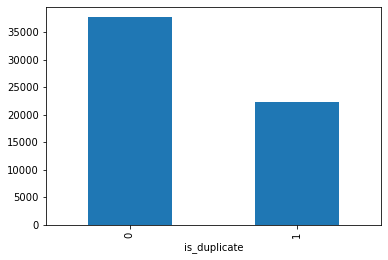

In [64]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [65]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   62.81%

~> Question pairs are Similar (is_duplicate = 1):
   37.19%


In [66]:
qids=pd.Series(df['qid1'].tolist()+df['qid2'].tolist())
unique_qs = len(np.unique(qids))
print(len(qids))
print("Unique_Ques=",unique_qs)
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print("Repeated_Ques=",qs_morethan_onetime)

120000
Unique_Ques= 105243
Repeated_Ques= 9443


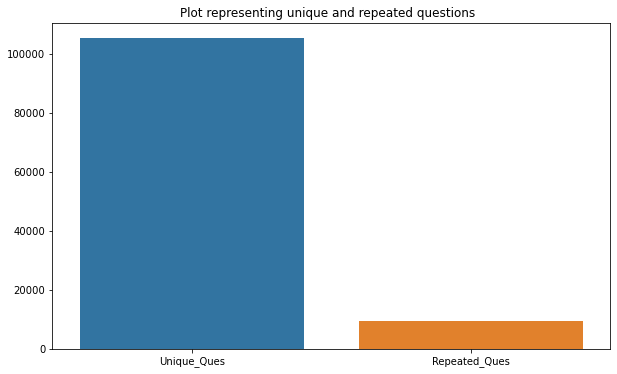

In [67]:
x=["Unique_Ques","Repeated_Ques"]
y=[unique_qs,qs_morethan_onetime]
plt.figure(figsize=(10,6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

In [68]:
qs_morethan_onetime

9443

Maximum number of times a single question is repeated: 23



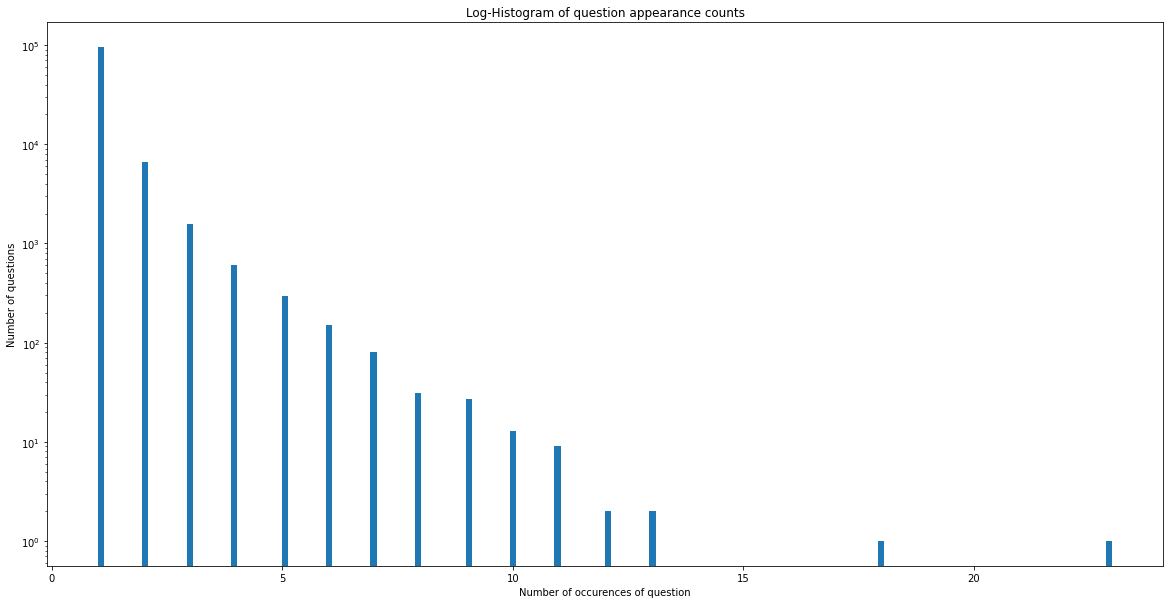

In [69]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

In [70]:
df

,id,qid1,qid2,question1,question2,is_duplicate
331535,331535,169053,295926,How can I learn Norwegian?,What is the quickest way to learn Norwegian?,1
45407,45407,81383,81384,How are currency rates determined?,Where and how are exchange rates determined?,1
286200,286200,285024,406729,What is substitution?,What is a substitute for caciocavallo?,0
157195,157195,245856,245857,How can I make iPhone 4s faster with IOS 9.2?,I have an iPhone 4S. How do I make it faster a...,1
154346,154346,242075,242076,How can I help my girlfriend cope with her par...,What can I do to help my girlfriend through he...,1
...,...,...,...,...,...,...
132858,132858,212652,212653,What is the value of 0^0?,What is the value of 0^0 and why?,1
279415,279415,71930,82307,Why Spotify is not available in India?,Daniel Ek: Why isn't Spotify available in Indi...,1
132565,132565,212229,51342,How can I overcome my fear of meeting girls?,How do I get the confidence to talk to girls?,0
317888,317888,33276,136941,What is the best platform/media/source to lear...,How do I get started to learning digital marke...,1


1. q1len=length of question 1
2. q2len=length of question 2
3. r_length=ration of q1len by q2len
4. q1_n_words=words in question 1
5. q2_n_words=words in question 2

In [71]:
def feature_extraction(df):

    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['r_len'] = df['q1len']/df['q2len']
    #df.drop(['q1len','q2len'],axis = 1,inplace = True)
    
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))


    
    return(df)

1. w1 = set of all words in question1 column
2. w2 = set of all words in question2 column
3. word_share = ratio of common words in w1 and w2 with total words in w1 and w2 

In [72]:
def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

In [73]:
df=feature_extraction(df)

In [74]:
df

,id,qid1,qid2,question1,question2,is_duplicate,word_share,q1len,q2len,r_len,q1_n_words,q2_n_words
331535,331535,169053,295926,How can I learn Norwegian?,What is the quickest way to learn Norwegian?,1,0.153846,26,44,0.590909,5,8
45407,45407,81383,81384,How are currency rates determined?,Where and how are exchange rates determined?,1,0.333333,34,44,0.772727,5,7
286200,286200,285024,406729,What is substitution?,What is a substitute for caciocavallo?,0,0.222222,21,38,0.552632,3,6
157195,157195,245856,245857,How can I make iPhone 4s faster with IOS 9.2?,I have an iPhone 4S. How do I make it faster a...,1,0.200000,45,73,0.616438,10,16
154346,154346,242075,242076,How can I help my girlfriend cope with her par...,What can I do to help my girlfriend through he...,1,0.347826,59,64,0.921875,11,12
...,...,...,...,...,...,...,...,...,...,...,...,...
132858,132858,212652,212653,What is the value of 0^0?,What is the value of 0^0 and why?,1,0.357143,25,33,0.757576,6,8
279415,279415,71930,82307,Why Spotify is not available in India?,Daniel Ek: Why isn't Spotify available in Indi...,1,0.315789,38,79,0.481013,7,14
132565,132565,212229,51342,How can I overcome my fear of meeting girls?,How do I get the confidence to talk to girls?,0,0.166667,44,45,0.977778,9,10
317888,317888,33276,136941,What is the best platform/media/source to lear...,How do I get started to learning digital marke...,1,0.166667,66,51,1.294118,9,9


minimum characters 1
maximum characters 391
average num of characters 59


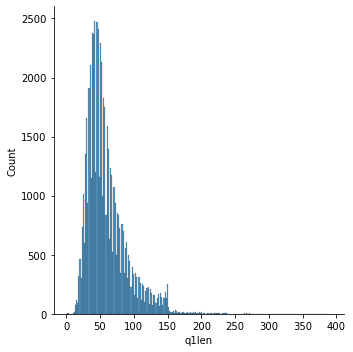

In [75]:
sns.displot(df['q1len'])
print('minimum characters',df['q1len'].min())
print('maximum characters',df['q1len'].max())
print('average num of characters',int(df['q1len'].mean()))

minimum characters 1
maximum characters 1169
average num of characters 60


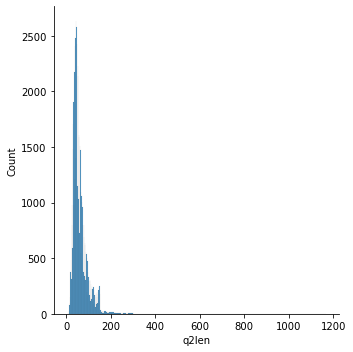

In [76]:
sns.displot(df['q2len'])
print('minimum characters',df['q2len'].min())
print('maximum characters',df['q2len'].max())
print('average num of characters',int(df['q2len'].mean()))

In [77]:
df["q1len"]=(df["q1len"]-df["q1len"].mean())/df["q1len"].std()
df["q2len"]=(df["q2len"]-df["q2len"].mean())/df["q2len"].std()

In [78]:
df

,id,qid1,qid2,question1,question2,is_duplicate,word_share,q1len,q2len,r_len,q1_n_words,q2_n_words
331535,331535,169053,295926,How can I learn Norwegian?,What is the quickest way to learn Norwegian?,1,0.153846,-1.122438,-0.474790,0.590909,5,8
45407,45407,81383,81384,How are currency rates determined?,Where and how are exchange rates determined?,1,0.333333,-0.855811,-0.474790,0.772727,5,7
286200,286200,285024,406729,What is substitution?,What is a substitute for caciocavallo?,0,0.222222,-1.289080,-0.650455,0.552632,3,6
157195,157195,245856,245857,How can I make iPhone 4s faster with IOS 9.2?,I have an iPhone 4S. How do I make it faster a...,1,0.200000,-0.489198,0.374256,0.616438,10,16
154346,154346,242075,242076,How can I help my girlfriend cope with her par...,What can I do to help my girlfriend through he...,1,0.347826,-0.022601,0.110759,0.921875,11,12
...,...,...,...,...,...,...,...,...,...,...,...,...
132858,132858,212652,212653,What is the value of 0^0?,What is the value of 0^0 and why?,1,0.357143,-1.155766,-0.796842,0.757576,6,8
279415,279415,71930,82307,Why Spotify is not available in India?,Daniel Ek: Why isn't Spotify available in Indi...,1,0.315789,-0.722497,0.549921,0.481013,7,14
132565,132565,212229,51342,How can I overcome my fear of meeting girls?,How do I get the confidence to talk to girls?,0,0.166667,-0.522527,-0.445513,0.977778,9,10
317888,317888,33276,136941,What is the best platform/media/source to lear...,How do I get started to learning digital marke...,1,0.166667,0.210698,-0.269848,1.294118,9,9


In [79]:
from tqdm import tqdm
df=df.drop(index for index, row in tqdm(df.iterrows()) if(row["q1len"]>2 or row["q1len"]<-2 or row["q2len"]>2 or row["q2len"]<-2))

60000it [00:04, 13745.34it/s]


In [80]:
df.shape

(54535, 12)

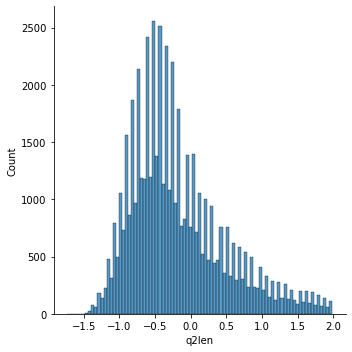

In [81]:
sns.displot(df['q2len'])

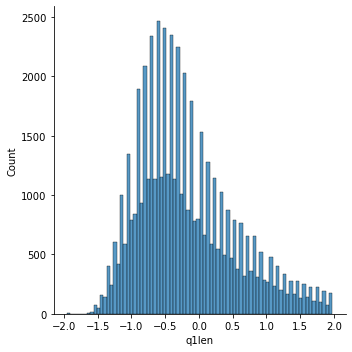

In [82]:
sns.displot(df['q1len'])

In [83]:
x = df
y = df["is_duplicate"]
x.reset_index(inplace = True)
x.drop(['index'],axis=1,inplace = True)

In [84]:
y

331535    1
45407     1
286200    0
157195    1
154346    1
         ..
132858    1
279415    1
132565    0
317888    1
19333     0
Name: is_duplicate, Length: 54535, dtype: int64

# sum of total_unique_words in question1 and question2

In [85]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

In [86]:
df['word_total'] = df.apply(total_words, axis=1)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,word_share,q1len,q2len,r_len,q1_n_words,q2_n_words,word_total
0,331535,169053,295926,How can I learn Norwegian?,What is the quickest way to learn Norwegian?,1,0.153846,-1.122438,-0.474790,0.590909,5,8,13
1,45407,81383,81384,How are currency rates determined?,Where and how are exchange rates determined?,1,0.333333,-0.855811,-0.474790,0.772727,5,7,12
2,286200,285024,406729,What is substitution?,What is a substitute for caciocavallo?,0,0.222222,-1.289080,-0.650455,0.552632,3,6,9
3,157195,245856,245857,How can I make iPhone 4s faster with IOS 9.2?,I have an iPhone 4S. How do I make it faster a...,1,0.200000,-0.489198,0.374256,0.616438,10,16,25
4,154346,242075,242076,How can I help my girlfriend cope with her par...,What can I do to help my girlfriend through he...,1,0.347826,-0.022601,0.110759,0.921875,11,12,23


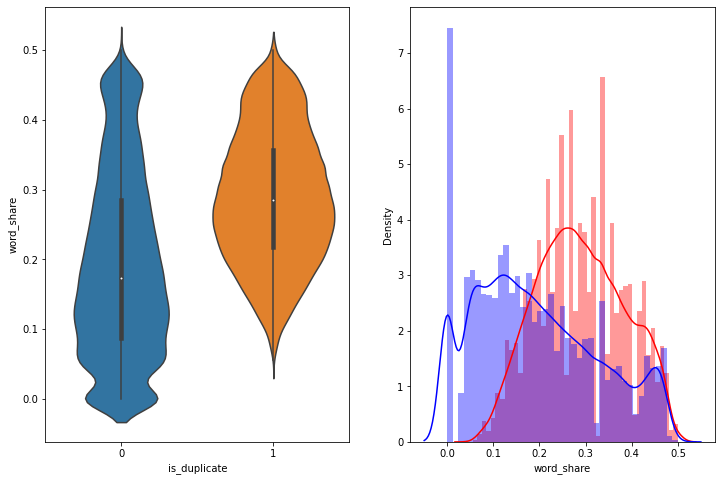

In [87]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

3. word_share = ratio of common words in w1 and w2 with total words in w1 and w2 

In [88]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

In [89]:
df['word_common'] = df.apply(common_words, axis=1)

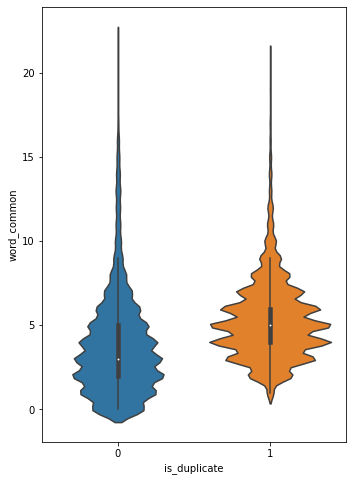

In [90]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_common', data = df[0:])

plt.show()

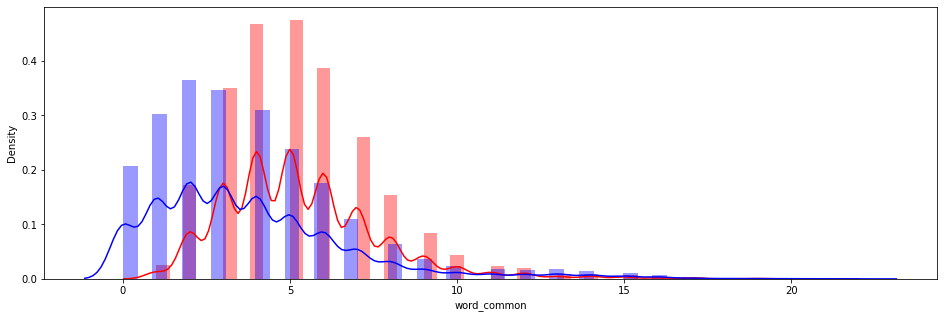

In [91]:
plt.figure(figsize=(16, 5))
sns.distplot(df[df['is_duplicate'] == 1.0]['word_common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_common'][0:] , label = "0" , color = 'blue' )
plt.show()

## Preprocessing of Text

#### > Preprocessing:


1. Removing html tags
2. Removing Punctuations
3. Performing stemming
4. Removing Stopwords
5. Expanding contractions etc.

In [92]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
     "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q,'lxml')
    q = q.get_text()
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()
    
    ps = PorterStemmer()
    words = word_tokenize(q)
    
    l = []
    for i in words:
        l.append(ps.stem(i))
    x = " ".join([str(e) for e in l])
    


    return q

In [93]:
preprocess("I've already! wasn't already <b>done</b>?")

'i have already  was not already done'

In [94]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)

In [95]:
def feature_extraction(df):

    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['r_len'] = df['q1len']/df['q2len']
    #df.drop(['q1len','q2len'],axis = 1,inplace = True)
    
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))


    
    return(df)
df=feature_extraction(df)
############################################################
def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

df["q1len"]=(df["q1len"]-df["q1len"].mean())/df["q1len"].std()
df["q2len"]=(df["q2len"]-df["q2len"].mean())/df["q2len"].std()
############################################################

def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

df['word_total'] = df.apply(total_words, axis=1)
############################################################

def common_words(x):
    l_1 = x['question1'].str.lower().str.split()
    l_2 = x['question2'].str.lower().str.split()
    len_common=[]
    for i in range(len(l_1)):
        
        l_1[i] = set(l_1[i])
        l_2[i] = set(l_2[i])
        len_common.append(len(l_1[i] & l_2[i]))
    x['c_words'] = len_common
    return(x)
common_words(x)
############################################################
df

,id,qid1,qid2,question1,question2,is_duplicate,word_share,q1len,q2len,r_len,q1_n_words,q2_n_words,word_total,word_common,c_words
0,331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1,0.153846,-1.304806,-0.444533,0.581395,5,8,13,2,2
1,45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1,0.333333,-0.932959,-0.444533,0.767442,5,7,12,4,4
2,286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0,0.222222,-1.537211,-0.709900,0.540541,3,6,9,2,2
3,157195,245856,245857,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...,1,0.222222,-0.421668,0.838073,0.611111,11,17,27,5,6
4,154346,242075,242076,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,1,0.347826,0.229065,0.440022,0.920635,11,12,23,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54530,132858,212652,212653,what is the value of 0 0,what is the value of 0 0 and why,1,0.428571,-1.351287,-0.931039,0.750000,7,9,14,5,6
54531,279415,71930,82307,why spotify is not available in india,daniel ek why is not spotify available in ind...,1,0.350000,-0.747035,1.147667,0.468354,7,17,20,6,7
54532,132565,212229,51342,how can i overcome my fear of meeting girls,how do i get the confidence to talk to girls,0,0.166667,-0.468149,-0.400305,0.977273,9,10,18,3,3
54533,317888,33276,136941,what is the best platform media source to lear...,how do i get started to learning digital marke...,1,0.150000,0.554432,-0.134939,1.300000,11,9,20,3,3


In [96]:
# Advanced Features
from nltk.corpus import stopwords

def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [97]:
token_features = df.apply(fetch_token_features, axis=1)

df["cwc_min"]       = list(map(lambda x: x[0], token_features))
df["cwc_max"]       = list(map(lambda x: x[1], token_features))
df["csc_min"]       = list(map(lambda x: x[2], token_features))
df["csc_max"]       = list(map(lambda x: x[3], token_features))
df["ctc_min"]       = list(map(lambda x: x[4], token_features))
df["ctc_max"]       = list(map(lambda x: x[5], token_features))
df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [98]:
df

,id,qid1,qid2,question1,question2,is_duplicate,word_share,q1len,q2len,r_len,...,word_common,c_words,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
0,331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1,0.153846,-1.304806,-0.444533,0.581395,...,2,2,0.999950,0.499988,0.000000,0.000000,0.399992,0.249997,1,0
1,45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1,0.333333,-0.932959,-0.444533,0.767442,...,4,4,0.666644,0.666644,0.999950,0.499988,0.799984,0.571420,1,0
2,286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0,0.222222,-1.537211,-0.709900,0.540541,...,2,2,0.000000,0.000000,0.999950,0.499988,0.666644,0.333328,0,1
3,157195,245856,245857,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...,1,0.222222,-0.421668,0.838073,0.611111,...,5,6,0.666656,0.571420,0.499988,0.222220,0.545450,0.374998,0,0
4,154346,242075,242076,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,1,0.347826,0.229065,0.440022,0.920635,...,8,8,0.999975,0.799984,0.666656,0.499994,0.727266,0.666661,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54530,132858,212652,212653,what is the value of 0 0,what is the value of 0 0 and why,1,0.428571,-1.351287,-0.931039,0.750000,...,5,6,0.999950,0.999950,0.999975,0.666656,0.857131,0.666659,0,1
54531,279415,71930,82307,why spotify is not available in india,daniel ek why is not spotify available in ind...,1,0.350000,-0.747035,1.147667,0.468354,...,6,7,0.999967,0.499992,0.999975,0.666656,0.999986,0.466664,1,0
54532,132565,212229,51342,how can i overcome my fear of meeting girls,how do i get the confidence to talk to girls,0,0.166667,-0.468149,-0.400305,0.977273,...,3,3,0.249994,0.249994,0.399992,0.399992,0.333330,0.299997,1,1
54533,317888,33276,136941,what is the best platform media source to lear...,how do i get started to learning digital marke...,1,0.150000,0.554432,-0.134939,1.300000,...,3,3,0.399992,0.285710,0.249994,0.249994,0.333330,0.272725,1,0


In [99]:
import distance

def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    #strs = list(distance.lcsubstrings(q1, q2))
    #length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features
    

In [100]:
length_features = df.apply(fetch_length_features, axis=1)

df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
df['mean_len'] = list(map(lambda x: x[1], length_features))
#df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [101]:
print(df.shape)
df.head()

(54535, 25)


,id,qid1,qid2,question1,question2,is_duplicate,word_share,q1len,q2len,r_len,...,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len
0,331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1,0.153846,-1.304806,-0.444533,0.581395,...,0.999950,0.499988,0.000000,0.000000,0.399992,0.249997,1,0,3,6.5
1,45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1,0.333333,-0.932959,-0.444533,0.767442,...,0.666644,0.666644,0.999950,0.499988,0.799984,0.571420,1,0,2,6.0
2,286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0,0.222222,-1.537211,-0.709900,0.540541,...,0.000000,0.000000,0.999950,0.499988,0.666644,0.333328,0,1,3,4.5
3,157195,245856,245857,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...,1,0.222222,-0.421668,0.838073,0.611111,...,0.666656,0.571420,0.499988,0.222220,0.545450,0.374998,0,0,5,13.5
4,154346,242075,242076,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,1,0.347826,0.229065,0.440022,0.920635,...,0.999975,0.799984,0.666656,0.499994,0.727266,0.666661,1,0,1,11.5


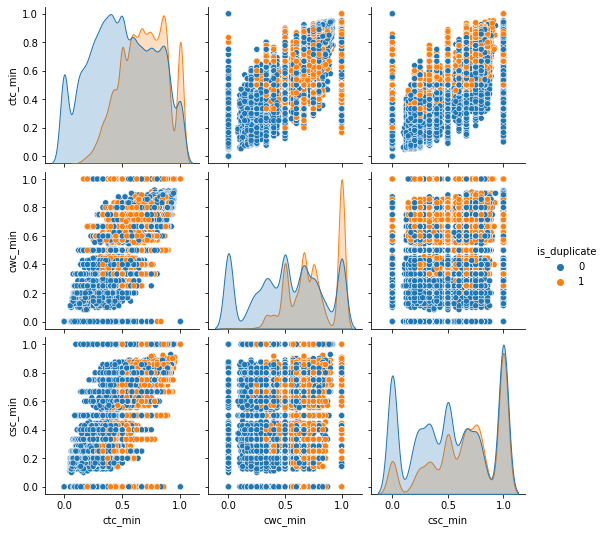

In [102]:
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

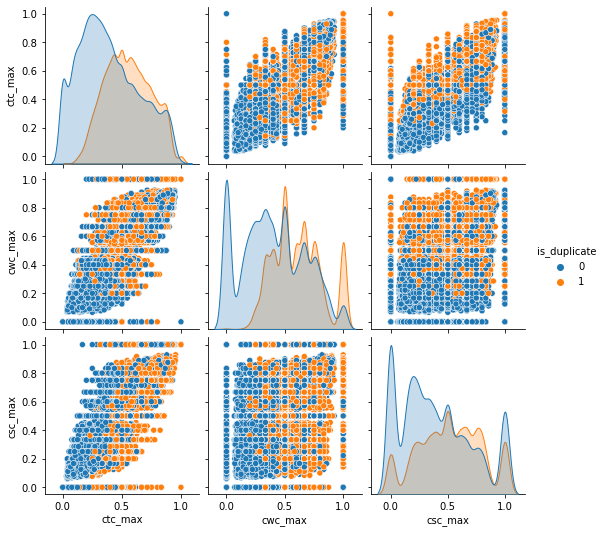

In [103]:
sns.pairplot(df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

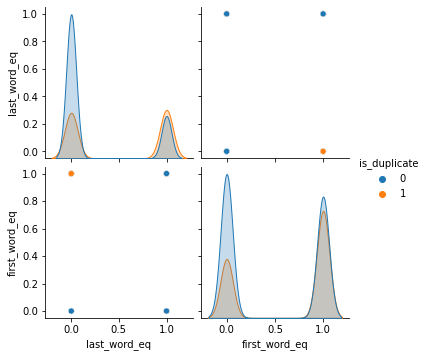

In [104]:
sns.pairplot(df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

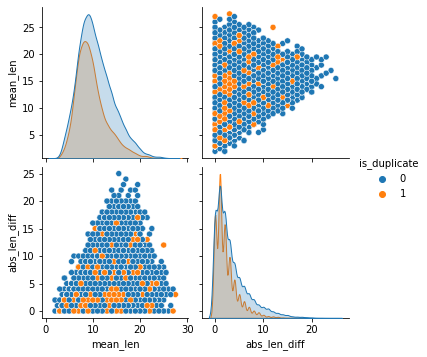

In [105]:
sns.pairplot(df[['mean_len', 'abs_len_diff', 'is_duplicate']],hue='is_duplicate')

In [106]:
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [107]:
fuzzy_features =df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

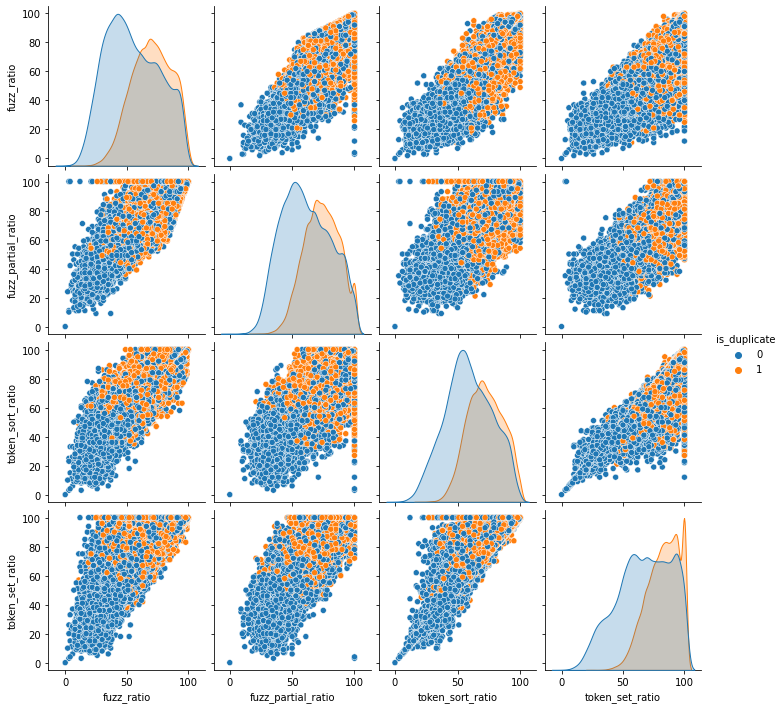

In [108]:
sns.pairplot(df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

In [93]:
from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(df[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' ]])
y = df['is_duplicate'].values

In [94]:
df

,id,qid1,qid2,question1,question2,is_duplicate,word_share,q1len,q2len,r_len,...,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1,0.153846,-1.307603,-0.437355,0.581395,...,0.399992,0.249997,1,0,3,6.5,59,68,50,75
1,45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1,0.333333,-0.931139,-0.437355,0.767442,...,0.799984,0.571420,1,0,2,6.0,71,82,63,84
2,286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0,0.222222,-1.542893,-0.706257,0.540541,...,0.666644,0.333328,0,1,3,4.5,67,85,60,60
3,157195,245856,245857,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster an...,1,0.230769,-0.413502,0.817523,0.619718,...,0.545450,0.374998,0,0,5,13.5,45,55,61,76
4,154346,242075,242076,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,1,0.347826,0.245310,0.458986,0.920635,...,0.727266,0.666661,1,0,1,11.5,81,81,78,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54530,132858,212652,212653,what is the value of 0 0,what is the value of 0 0 and why,1,0.428571,-1.354661,-0.930343,0.750000,...,0.857131,0.666659,0,1,2,8.0,86,100,86,100
54531,279415,71930,82307,why spotify is not available in india,daniel ek why is not spotify available in indi...,1,0.368421,-0.742907,1.086425,0.480519,...,0.999986,0.466664,1,0,8,11.0,53,81,65,100
54532,132565,212229,51342,how can i overcome my fear of meeting girls,how do i get the confidence to talk to girls,0,0.166667,-0.460560,-0.392538,0.977273,...,0.333330,0.299997,1,1,1,9.5,51,49,48,50
54533,317888,33276,136941,what is the best platform media source to lear...,how do i get started to learning digital marke...,1,0.150000,0.574715,-0.123635,1.300000,...,0.333330,0.272725,1,0,2,10.0,63,72,54,59


In [95]:
X.shape

(54535, 14)

In [64]:
from sklearn.manifold import TSNE

tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 91016 samples in 2.354s...
[t-SNE] Computed neighbors for 91016 samples in 36.159s...
[t-SNE] Computed conditional probabilities for sample 1000 / 91016
[t-SNE] Computed conditional probabilities for sample 2000 / 91016
[t-SNE] Computed conditional probabilities for sample 3000 / 91016
[t-SNE] Computed conditional probabilities for sample 4000 / 91016
[t-SNE] Computed conditional probabilities for sample 5000 / 91016
[t-SNE] Computed conditional probabilities for sample 6000 / 91016
[t-SNE] Computed conditional probabilities for sample 7000 / 91016
[t-SNE] Computed conditional probabilities for sample 8000 / 91016
[t-SNE] Computed conditional probabilities for sample 9000 / 91016
[t-SNE] Computed conditional probabilities for sample 10000 / 91016
[t-SNE] Computed conditional probabilities for sample 11000 / 91016
[t-SNE] Computed conditional probabilities for sample 12000 / 91016
[t-SNE] Computed conditional probabilities for sa

[t-SNE] Iteration 950: error = 2.7951303, gradient norm = 0.0000936 (50 iterations in 25.794s)
[t-SNE] Iteration 1000: error = 2.7353003, gradient norm = 0.0000864 (50 iterations in 27.622s)
[t-SNE] KL divergence after 1000 iterations: 2.735300


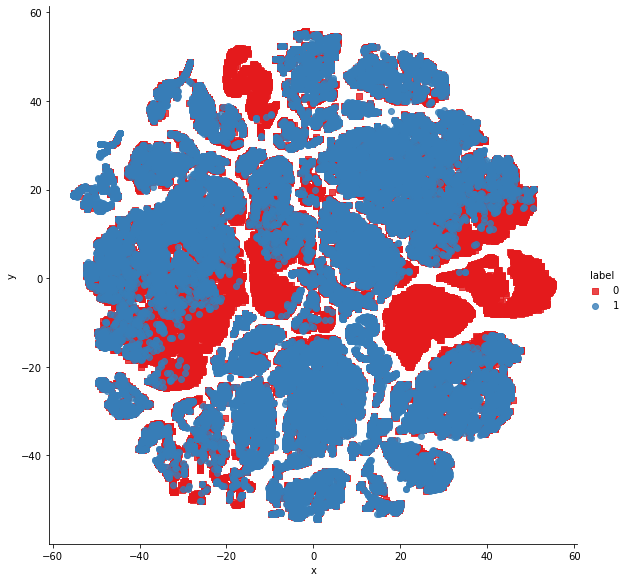

In [65]:
x_df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=x_df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])

In [ ]:
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

In [ ]:
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.offline as py
py.init_notebook_mode(connected=True)

trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

In [96]:
ques_df = df[['question1','question2']]
ques_df.head()

,question1,question2
0,how can i learn norwegian,what is the quickest way to learn norwegian
1,how are currency rates determined,where and how are exchange rates determined
2,what is substitution,what is a substitute for caciocavallo
3,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster an...
4,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...


In [97]:
final_df = df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(54535, 24)


,is_duplicate,word_share,q1len,q2len,r_len,q1_n_words,q2_n_words,word_total,word_common,c_words,...,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,1,0.153846,-1.307603,-0.437355,0.581395,5,8,13,2,2,...,0.399992,0.249997,1,0,3,6.5,59,68,50,75
1,1,0.333333,-0.931139,-0.437355,0.767442,5,7,12,4,4,...,0.799984,0.571420,1,0,2,6.0,71,82,63,84
2,0,0.222222,-1.542893,-0.706257,0.540541,3,6,9,2,2,...,0.666644,0.333328,0,1,3,4.5,67,85,60,60
3,1,0.230769,-0.413502,0.817523,0.619718,11,16,26,5,6,...,0.545450,0.374998,0,0,5,13.5,45,55,61,76
4,1,0.347826,0.245310,0.458986,0.920635,11,12,23,8,8,...,0.727266,0.666661,1,0,1,11.5,81,81,78,86


In [98]:
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])



In [99]:
cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [100]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(54535, 6000)

In [101]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(54535, 6024)


,is_duplicate,word_share,q1len,q2len,r_len,q1_n_words,q2_n_words,word_total,word_common,c_words,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,1,0.153846,-1.307603,-0.437355,0.581395,5,8,13,2,2,...,0,0,0,0,0,0,0,0,0,0
1,1,0.333333,-0.931139,-0.437355,0.767442,5,7,12,4,4,...,0,0,0,0,0,0,0,0,0,0
2,0,0.222222,-1.542893,-0.706257,0.540541,3,6,9,2,2,...,0,0,0,0,0,0,0,0,0,0
3,1,0.230769,-0.413502,0.817523,0.619718,11,16,26,5,6,...,0,0,0,0,0,0,0,0,0,0
4,1,0.347826,0.245310,0.458986,0.920635,11,12,23,8,8,...,0,0,0,0,0,0,0,0,0,0


In [102]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

In [103]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7833501421105712

In [61]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)
accuracy_score(y_test,y_pred1)

0.7873842486476574

In [62]:
df

,id,qid1,qid2,question1,question2,is_duplicate,word_share,q1len,q2len,r_len,...,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,331535,169053,295926,how can i learn norwegian,what is the quickest way to learn norwegian,1,0.153846,-1.304806,-0.444533,0.581395,...,0.399992,0.249997,1,0,3,6.5,59,68,50,75
1,45407,81383,81384,how are currency rates determined,where and how are exchange rates determined,1,0.333333,-0.932959,-0.444533,0.767442,...,0.799984,0.571420,1,0,2,6.0,71,82,63,84
2,286200,285024,406729,what is substitution,what is a substitute for caciocavallo,0,0.222222,-1.537211,-0.709900,0.540541,...,0.666644,0.333328,0,1,3,4.5,67,85,60,60
3,157195,245856,245857,how can i make iphone 4s faster with ios 9 2,i have an iphone 4s how do i make it faster a...,1,0.222222,-0.421668,0.838073,0.611111,...,0.545450,0.374998,0,0,5,13.5,45,55,61,76
4,154346,242075,242076,how can i help my girlfriend cope with her par...,what can i do to help my girlfriend through he...,1,0.347826,0.229065,0.440022,0.920635,...,0.727266,0.666661,1,0,1,11.5,81,81,78,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54530,132858,212652,212653,what is the value of 0 0,what is the value of 0 0 and why,1,0.428571,-1.351287,-0.931039,0.750000,...,0.857131,0.666659,0,1,2,8.0,86,100,86,100
54531,279415,71930,82307,why spotify is not available in india,daniel ek why is not spotify available in ind...,1,0.350000,-0.747035,1.147667,0.468354,...,0.999986,0.466664,1,0,8,11.0,52,81,65,100
54532,132565,212229,51342,how can i overcome my fear of meeting girls,how do i get the confidence to talk to girls,0,0.166667,-0.468149,-0.400305,0.977273,...,0.333330,0.299997,1,1,1,9.5,51,49,48,50
54533,317888,33276,136941,what is the best platform media source to lear...,how do i get started to learning digital marke...,1,0.150000,0.554432,-0.134939,1.300000,...,0.333330,0.272725,1,0,2,10.0,63,72,54,59
